In [2]:
using Flux
using MLToolkit: flatten_dict, dict2namedtuple
using Random: seed!

using Revise
using RMMMDNets

;

┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1242
┌ Info: Precompiling MLToolkit [519e820e-097c-11e9-2274-1b004aeb0b9b]
└ @ Base loading.jl:1242
┌ Warning: Module Flux with build ID 310579669765114 is missing from the cache.
│ This may mean Flux [587475ba-b771-5e3f-ad9e-33799f191a9c] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1000
┌ Info: Skipping precompilation since __precompile__(false). Importing MLToolkit [519e820e-097c-11e9-2274-1b004aeb0b9b].
└ @ Base loading.jl:1017
┌ Info: Precompiling RMMMDNets [7ea7fd3b-14e3-4223-94d2-c341911ad28e]
└ @ Base loading.jl:1242
┌ Warning: Module Flux with build ID 310579669765114 is missing from the cache.
│ This may mean Flux [587475ba-b771-5e3f-ad9e-33799f191a9c] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1000
┌ Info: Skipping precompilation since __precompile__(false). Importing RMMMDNets [7ea7fd3b-14e3-4223-9

┌ Info: Args
│   batch_size_gen = 200
│   batch_size = 200
│   Dg_h = 100,100
│   σ_last = identity
│   D_z = 50
│   D_fx = 3
│   dataset = gaussian
│   σ = tanh
│   opt = adam
│   model_name = gan
│   n_epochs = 1000
│   Dd_h = 50,25
│   base = uniform
│   lr = 0.005
│   seed = 1234
└ @ Main /afs/inf.ed.ac.uk/user/s16/s1672897/projects/RMMMDNets.jl/scripting.jl:98
┌ Info: Init gan with 16,853 parameters
│   logdir = gaussian/gan/opt=adam-σ=tanh-Dg_h=100,100-Dd_h=50,25-base=uniform-D_fx=3-D_z=50/23092019-3-27-3
└ @ RMMMDNets /afs/inf.ed.ac.uk/user/s16/s1672897/projects/RMMMDNets.jl/src/RMMMDNets.jl:108
Progress: 100%|█████████████████████████████████████████| Time: 0:03:30


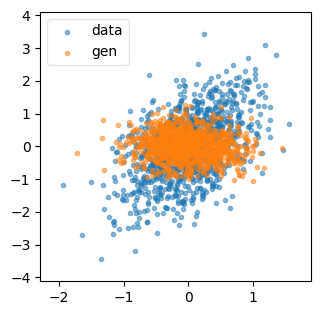

In [23]:
RMMMDNets_PATH = pathof(RMMMDNets) |> splitdir |> first |> splitdir |> first
include("$RMMMDNets_PATH/scripting.jl")

dataset = "gaussian"
#  dataset = "ring"
# dataset = "mnist"

model_name = "gan"
# model_name = "mmdnet"
# model_name = "rmmmdnet"

args = get_args(dataset, model_name; override=(lr=5f-3))

###

function run_exp(args)
    data = get_data(args.dataset)
    
    seed!(args.seed)

    model = get_model(args, data)

    evaluate(data, model)

    dataloader = DataLoader(data, args.batch_size)
    
    train!(model, args.n_epochs, dataloader)
    
    return data, model
end

data, model = run_exp(args)

;

In [22]:
using Statistics: mean
using RMMMDNets: update_by_loss!

function RMMMDNets.step!(m::RMMMDNets.GAN, x_data)
    # Training mode
    Flux.testmode!(m.d, false)
    Flux.testmode!(m.g, false)
    
    # Update D
    x_gen = rand(m.g)
    logitŷ = m.d(hcat(x_data, x_gen))
    batch_size=last(size(x_data))
    batch_size_gen=last(size(x_gen))
    y = vcat(ones(batch_size_gen), zeros(batch_size))'
    loss_d = mean(Flux.logitbinarycrossentropy.(logitŷ, y))
    update_by_loss!(loss_d, m.ps_d, m.opt)

    # Update G
    x_gen = rand(m.g)
    logitŷ = m.d(hcat(x_gen, x_data))
    loss_g = mean(log.(1 .- sigmoid.(logitŷ)))
    (loss_g, m.ps_g, m.opt)

    return (
        loss_d=loss_d,
        loss_g=loss_g, 
        batch_size=batch_size, 
        batch_size_gen=batch_size_gen,
        lr=m.opt.eta,
    )
end